In [1]:
!pip install catboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Users\ellah\OneDrive\Data Science Projects\Drug Data\Copy of Accidental_Drug_Related_Deaths_2012-2022.csv")

In [4]:
df.head

<bound method NDFrame.head of              Date      Date Type   Age     Sex                       Race  \
0      05/29/2012  Date of death  37.0    Male                      Black   
1      06/27/2012  Date of death  37.0    Male                      White   
2      03/24/2014  Date of death  28.0    Male                      White   
3      12/31/2014  Date of death  26.0  Female                      White   
4      01/16/2016  Date of death  41.0    Male                      White   
...           ...            ...   ...     ...                        ...   
10649  08/15/2022  Date of death  60.0    Male                      White   
10650  01/30/2022  Date of death  65.0    Male                      White   
10651  09/17/2022  Date of death  41.0    Male  Black or African American   
10652  12/20/2022  Date of death  59.0    Male                      White   
10653  09/08/2022  Date of death  49.0    Male                      White   

      Ethnicity Residence City Residence Coun

In [5]:
df["Date"]=pd.to_datetime(df["Date"])

df["Year"]=df["Date"].dt.year
df["Month"]=df["Date"].dt.month


df = df[df["Date Type"] != "Date reported"]


df["Ethnicity"]= df["Ethnicity"].fillna("Unknown")

ethnicity_map = {
    "Unknown":0,
    "Not Spanish/Hispanic/Latino":0
}
df["Ethnicity"] = df["Ethnicity"].map(ethnicity_map).fillna(1).astype(int)

columns_to_fill = ["Heroin death certificate (DC)", "Other", "Sex", "Description of Injury", "Race", "Residence City", "Residence County", "Residence State", "Injury City", "Injury County", "Injury State", "Injury Place", "Death City", "Death County", "Death State", "Location", "Location if Other",'Cause of Death', 'Manner of Death','Other Significant Conditions ', 'Year', 'Month']
df[columns_to_fill] = df[columns_to_fill].fillna("Unknown")

columns_mean = ["Age"]
df[columns_mean] = df[columns_mean].fillna(df[columns_mean].mean())


columns_to_transform = ["Heroin", 'Cocaine', 'Fentanyl','Fentanyl Analogue', 'Oxycodone', 'Oxymorphone', 'Ethanol',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine',
       'Amphet', 'Tramad', 'Hydromorphone', 'Morphine (Not Heroin)',
       'Xylazine', 'Gabapentin', 'Opiate NOS', 'Heroin/Morph/Codeine',
       'Other Opioid', 'Any Opioid']
df[columns_to_transform] = df[columns_to_transform].replace({"y":1, "Y":1, "Y POPS":1, "Y (PTCH)":1, "P":1, "PCP NEG":0, "Buprenorphine":1,"PCP":1, "MDMA, Buprenorphine":1, "ketamine":1, "Mitragynine":1, "Difluro":1, "pcp":1, "N":0 }).fillna(0).astype(float)


df["Race"] = df["Race"].replace({"Black or African American":"Black"})
df["Race"] = df["Race"].replace({"American Indian or Alaska Native":"Other", "Native American, Other":"Other", "Hawaiian":"Other"})
df["Race"] = df["Race"].replace({"Asian, Other":"Asian", "Other Asian":"Asian", "Chinese":"Asian", "Korean":"Asian", "Asian/Indian":"Asian", "Asian Indian":"Asian"})

df["Combined Opiod"] = ((df['Other Opioid']==1) | (df['Any Opioid']==1) | (df['Opiate NOS']==1)).astype(int)


def my_clip(x):
    q1, q3 = x.quantile([.25,.75])
    iqr = q3 - q1
    low = q1 -(1.5*iqr)
    high = q3 + (1.5*iqr)

    return np.clip(x, low, high)
df["Age"] = pd.to_numeric(df["Age"])
df["Age"] = df["Age"].fillna(df["Age"].mean())
df["Age"] = my_clip(df["Age"])

min_count = 10
df = df[df.apply(lambda x: x.nunique() >= min_count, axis=1)]

df.set_index("Year")

C:\Users\ellah\AppData\Local\Temp\ipykernel_19412\102050474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ethnicity"]= df["Ethnicity"].fillna("Unknown")
C:\Users\ellah\AppData\Local\Temp\ipykernel_19412\102050474.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ethnicity"] = df["Ethnicity"].map(ethnicity_map).fillna(1).astype(int)
C:\Users\ellah\AppData\Local\Temp\ipykernel_19412\102050474.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Date,Date Type,Age,Sex,Race,Ethnicity,Residence City,Residence County,Residence State,Injury City,...,Opiate NOS,Heroin/Morph/Codeine,Other Opioid,Any Opioid,Other,ResidenceCityGeo,InjuryCityGeo,DeathCityGeo,Month,Combined Opiod
Year,,,,,,,,,,,,,,,,,,,,,
2012,2012-05-29,Date of death,37.0,Male,Black,0,STAMFORD,FAIRFIELD,Unknown,STAMFORD,...,0.0,0.0,0.0,0.0,Unknown,"STAMFORD, CT\n(41.051924, -73.539475)","STAMFORD, CT\n(41.051924, -73.539475)","CT\n(41.575155, -72.738288)",5,0
2012,2012-06-27,Date of death,37.0,Male,White,0,NORWICH,NEW LONDON,Unknown,NORWICH,...,0.0,0.0,0.0,0.0,Unknown,"NORWICH, CT\n(41.524304, -72.075821)","NORWICH, CT\n(41.524304, -72.075821)","Norwich, CT\n(41.524304, -72.075821)",6,0
2014,2014-03-24,Date of death,28.0,Male,White,0,HEBRON,Unknown,Unknown,HEBRON,...,0.0,0.0,0.0,0.0,Unknown,"HEBRON, CT\n(41.658069, -72.366324)","HEBRON, CT\n(41.658069, -72.366324)","Marlborough, CT\n(41.632043, -72.461309)",3,0
2014,2014-12-31,Date of death,26.0,Female,White,0,BALTIC,Unknown,Unknown,Unknown,...,0.0,0.0,0.0,0.0,Unknown,"BALTIC, CT\n(41.617221, -72.085031)","CT\n(41.575155, -72.738288)","Baltic, CT\n(41.617221, -72.085031)",12,0
2016,2016-01-16,Date of death,41.0,Male,White,0,SHELTON,FAIRFIELD,CT,SHELTON,...,0.0,0.0,0.0,1.0,Unknown,"SHELTON, CT\n(41.316843, -73.092968)","SHELTON, CT\n(41.316843, -73.092968)","Bridgeport, CT\n(41.179195, -73.189476)",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,2022-08-15,Date of death,60.0,Male,White,0,SOUTHINGTON,HARTFORD,CT,SOUTHINGTON,...,0.0,0.0,0.0,1.0,Unknown,"SOUTHINGTON, CT\n(41.600220000000036, -72.8781...","SOUTHINGTON, CT\n(41.600220000000036, -72.8781...","CT\n(41.57350273000003, -72.73830590799997)",8,1
2022,2022-01-30,Date of death,65.0,Male,White,0,HARTFORD,HARTFORD,CT,HARTFORD,...,0.0,1.0,1.0,1.0,Buprenorphine,"HARTFORD, CT\n(41.76376000000005, -72.67397999...","HARTFORD, CT\n(41.76376000000005, -72.67397999...","CT\n(41.57350273000003, -72.73830590799997)",1,1
2022,2022-09-17,Date of death,41.0,Male,Black,0,HARTFORD,HARTFORD,CT,HARTFORD,...,0.0,0.0,0.0,1.0,Unknown,"HARTFORD, CT\n(41.76376000000005, -72.67397999...","HARTFORD, CT\n(41.76376000000005, -72.67397999...","CT\n(41.57350273000003, -72.73830590799997)",9,1


In [6]:
df.columns

Index(['Date', 'Date Type', 'Age', 'Sex', 'Race', 'Ethnicity',
       'Residence City', 'Residence County', 'Residence State', 'Injury City',
       'Injury County', 'Injury State', 'Injury Place',
       'Description of Injury', 'Death City', 'Death County', 'Death State',
       'Location', 'Location if Other', 'Cause of Death', 'Manner of Death',
       'Other Significant Conditions ', 'Heroin',
       'Heroin death certificate (DC)', 'Cocaine', 'Fentanyl',
       'Fentanyl Analogue', 'Oxycodone', 'Oxymorphone', 'Ethanol',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine',
       'Amphet', 'Tramad', 'Hydromorphone', 'Morphine (Not Heroin)',
       'Xylazine', 'Gabapentin', 'Opiate NOS', 'Heroin/Morph/Codeine',
       'Other Opioid', 'Any Opioid', 'Other', 'ResidenceCityGeo',
       'InjuryCityGeo', 'DeathCityGeo', 'Year', 'Month', 'Combined Opiod'],
      dtype='object')

In [7]:
df["Manner of Death"].nunique()

5

In [8]:
df = df.drop(columns=["Cause of Death", "Date Type", "Location if Other", "Manner of Death", "ResidenceCityGeo", "InjuryCityGeo", "DeathCityGeo"])

In [9]:
df.shape

(8887, 44)

In [10]:
target_column  = ["Fentanyl"]

y = df[target_column]
X = df.drop(columns=target_column)

In [11]:
df.dtypes.value_counts()

float64           22
object            17
int64              2
int32              2
datetime64[ns]     1
Name: count, dtype: int64

In [15]:
numerical_features = X.select_dtypes(include = ['float64', 'int64', 'int32']).columns.to_list()

categorical_features = X.select_dtypes(include = ['object']).columns.to_list()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
categorical_features_cat_boost = X_train.select_dtypes(include=['object']).columns.tolist()

categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

In [18]:
X_train.shape

(7109, 43)

In [19]:
y_train.shape

(7109, 1)

In [20]:
categorical_pipeline = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]
)

numerical_pipeline = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)



In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', numerical_pipeline, numerical_features),
    ],
    sparse_threshold=0
)

In [22]:
random_forest_classifier = RandomForestClassifier(n_estimators=25, max_depth=25, random_state=42)

logistic_regression_classifier = LogisticRegression(max_iter=500, n_jobs=-1)

cat_booster_classifier = CatBoostClassifier(iterations=500, learning_rate=0.5, verbose=False, cat_features=categorical_indices)

In [23]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest_classifier', random_forest_classifier)
])

In [24]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic_regression_classifier', logistic_regression_classifier)
])

In [25]:
cb_pipeline = Pipeline(steps=[
    ('cat_booster_classifier', cat_booster_classifier)
])

In [26]:
print(type(categorical_features))
print(type(numerical_features))

<class 'list'>
<class 'list'>


In [27]:
rf_pipeline.fit(X_train, y_train)

c:\Users\ellah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,steps,"[('preprocessor', ...), ('random_forest_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
lr_pipeline.fit(X_train, y_train)

c:\Users\ellah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,steps,"[('preprocessor', ...), ('logistic_regression_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [30]:
cb_pipeline.fit(X_train, y_train)

,steps,"[('cat_booster_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False


In [31]:
print(rf_pipeline.score(X_train, y_train))
print(rf_pipeline.score(X_test, y_test))
print(lr_pipeline.score(X_train, y_train))
print(lr_pipeline.score(X_test, y_test))
print(cb_pipeline.score(X_test, y_test))
print(cb_pipeline.score(X_test, y_test))

0.9985933323955549
0.8976377952755905
0.8911239274159516
0.890888638920135
0.9116985376827896
0.9116985376827896


In [32]:
cb_model = cb_pipeline.named_steps['cat_booster_classifier']

importances = cb_model.get_feature_importance()

features = X_train.columns

In [33]:
importance_df = pd.DataFrame({
    'feature' : features,
    'importance' : importances
})

In [34]:
top_five = importance_df.sort_values(by='importance', ascending=False).head(5)

In [35]:
top_five.head()

,feature,importance
38,Any Opioid,15.078743
0,Date,6.423728
12,Description of Injury,5.902015
1,Age,4.468431
21,Fentanyl Analogue,4.221464


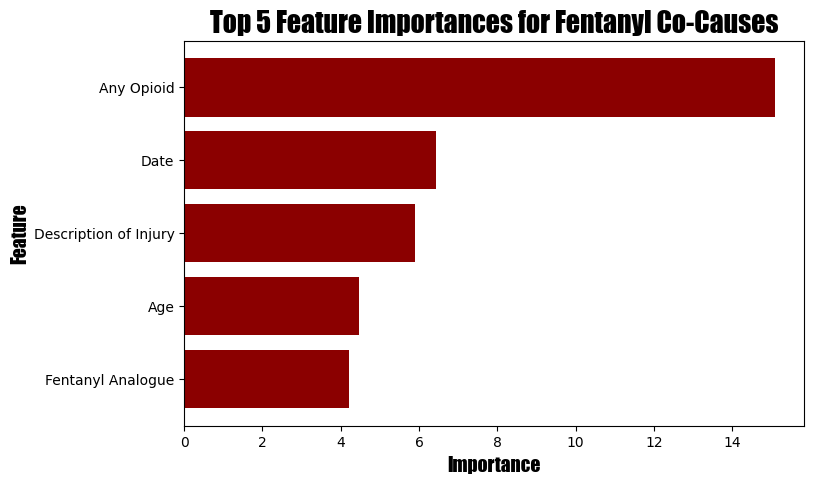

In [48]:
plt.figure(figsize=(8, 5))

colors = ['#8B0000']

plt.barh(top_five['feature'], top_five['importance'], color = colors)
plt.xlabel("Importance", fontsize = 14, fontname = 'Impact')
plt.ylabel("Feature", fontsize = 14, fontname = 'Impact')
plt.title("Top 5 Feature Importances for Fentanyl Co-Causes", fontsize = 20, fontname = "Impact")
plt.yticks(fontsize = 10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()  # Highest importance at top

plt.show()

In [49]:
df["Fentanyl"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: Fentanyl, dtype: float64

In [50]:
fentanyl_df = df[df["Fentanyl"] == 1]

In [51]:
daily_counts = fentanyl_df.groupby("Date").size()

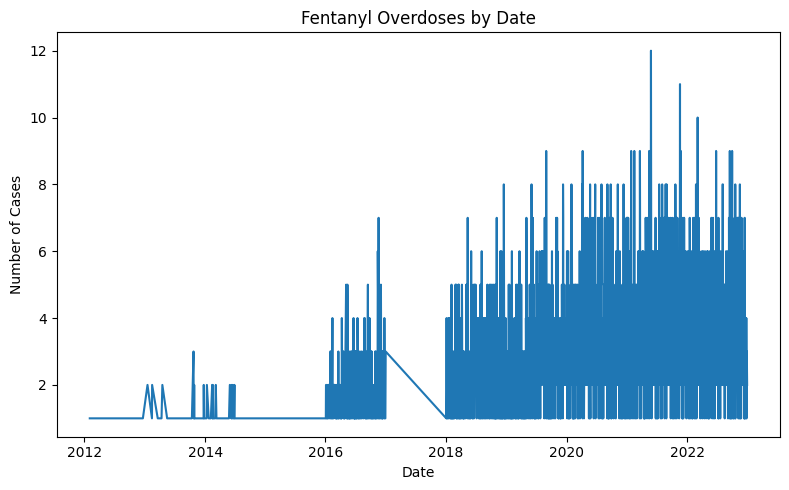

In [52]:
plt.figure(figsize=(8,5))

plt.plot(daily_counts.index, daily_counts.values)

plt.title("Fentanyl Overdoses by Date")
plt.xlabel("Date")
plt.ylabel("Number of Cases")

plt.tight_layout()
plt.show()

In [53]:
df["Month"] = df["Date"].dt.month

In [54]:
monthly_counts = df[df["Fentanyl"] == 1]["Month"].value_counts().sort_index()

In [55]:
monthly_counts

Month
1     427
2     414
3     475
4     484
5     523
6     566
7     563
8     525
9     519
10    503
11    531
12    530
Name: count, dtype: int64

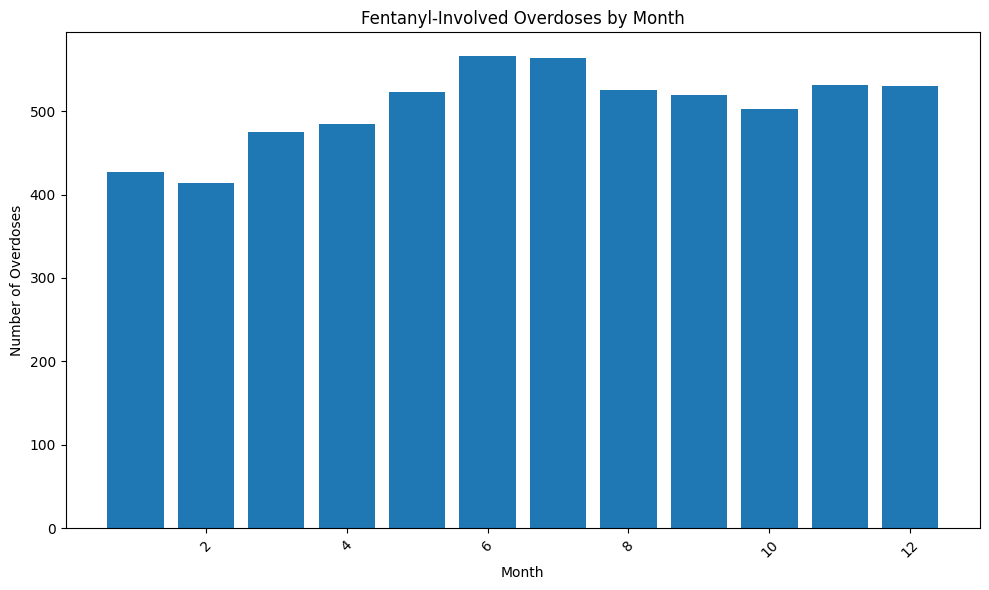

In [56]:
plt.figure(figsize=(10,6))
plt.bar(monthly_counts.index, monthly_counts.values)

plt.title("Fentanyl-Involved Overdoses by Month")
plt.xlabel("Month")
plt.ylabel("Number of Overdoses")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()